In [9]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Fetch dataset
nursery = fetch_ucirepo(id=76)

# Data (as pandas dataframes)
X = nursery.data.features
y = nursery.data.targets

# Metadata
print(nursery.metadata)

# Variable information
print(nursery.variables)
print(nursery.data.targets.value_counts())


{'uci_id': 76, 'name': 'Nursery', 'repository_url': 'https://archive.ics.uci.edu/dataset/76/nursery', 'data_url': 'https://archive.ics.uci.edu/static/public/76/data.csv', 'abstract': ' Nursery Database was derived from a hierarchical decision model originally developed to rank applications for nursery schools.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 12960, 'num_features': 8, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Sun Jan 14 2024', 'dataset_doi': '10.24432/C5P88W', 'creators': ['Vladislav Rajkovic'], 'intro_paper': {'ID': 372, 'type': 'NATIVE', 'title': 'An application for admission in public school systems', 'authors': 'M. Olave, V. Rajkovic, M. Bohanec', 'venue': 'Expert Systems in Public Administration', 'year': 1989, 'journal': None, 'DOI': None, 

In [11]:
# convert target variable to binary
y_binary = np.where((y == 'very_recom') | (y == 'recommend'), 1, 0)

# check the new distribution
unique, counts = np.unique(y_binary, return_counts=True)
print("binary class dist:")
print(dict(zip(unique, counts)))

def preprocess_data(X, y, model_type=None):
    y_binary = np.where((y == 'very_recom') | (y == 'recommend'), 1, 0)

    # make target y 1D
    y_binary = np.ravel(y_binary)

    # encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_binary)

    # one-hot encode categorical features
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X)

    scaler = StandardScaler()
    X_encoded = scaler.fit_transform(X_encoded)

    return X_encoded, y_encoded, label_encoder

binary class dist:
{np.int64(0): np.int64(12630), np.int64(1): np.int64(330)}


In [12]:

# define classifiers and hyperparameter grids
classifiers = {
    "SVM": {
        "model": SVC(),
        "param_grid": {
            "C": [10**i for i in range(-7, 4)],
            "kernel": ["linear", "poly", "rbf"],
            "degree": [2, 3],
            "gamma": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(n_estimators=1024),
        "param_grid": {
            "max_features": [1, 2, 4, 6, 8, 12, 16, 20]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "param_grid": {
            "C": [10**i for i in range(-8, 5)],
            "penalty": ["l2"],
            "solver": ["lbfgs"]
        }
    }
}

In [13]:
def evaluate_classifier_with_report(X_scaled, y_binary, model, param_grid, partitions, trials, label_encoder):
    results = []
    reports = []

    for trial in range(trials):
        print(f"\n-------- trial {trial + 1} --------")
        for train_size, test_size in partitions:
            #data split according to test and train size
            X_train, X_temp, y_train, y_temp = train_test_split(
                X_scaled, y_binary, train_size=train_size, random_state=trial, stratify=y_binary
            )

            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=trial, stratify=y_temp
            )

            #tune hyper and evaluate model
            randomized_search = RandomizedSearchCV(model, param_grid, n_iter=min(len(param_grid), 20), cv=3, scoring="accuracy", n_jobs=-1)
            randomized_search.fit(X_train, y_train)
            best_model = randomized_search.best_estimator_
            cross_val_score_mean = randomized_search.best_score_
            #get acc scores
            train_acc = accuracy_score(y_train, best_model.predict(X_train))
            val_acc = accuracy_score(y_val, best_model.predict(X_val))
            test_preds = best_model.predict(X_test)
            test_acc = accuracy_score(y_test, test_preds)
            # help w log results
            results.append({
                "trial": trial + 1,
                "partition": (train_size, test_size),
                "train_acc": train_acc,
                "val_acc": val_acc,
                "test_acc": test_acc,
                "cross_val_acc": cross_val_score_mean,
                "best_params": randomized_search.best_params_,
            })
            # generate classification report
            report = classification_report(y_test, test_preds,
                                           target_names=["Not Recommended", "Recommended"],
                                           output_dict=True, zero_division=0)  # Avoid warning
            reports.append({
                "trial": trial + 1,
                "partition": f"{int(train_size*100)}/{int(test_size*100)}",
                "classification_report": report
            })

            print(
                f"partition {int(train_size*100)}/{int(test_size*100)}:"
                f" train acc: {train_acc:.2f}, val acc: {val_acc:.2f}, test acc: {test_acc:.2f}"
            )
    return results, reports

In [14]:
def plot_heatmap(data, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [15]:
def main():
    X_scaled, y_encoded, label_encoder = preprocess_data(X, y, model_type=None)

    partitions = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]
    trials = 3
    all_results = {}
    avg_test_accuracies = {}
    avg_cv_accuracies = {}
    best_hyperparams = {}

    for clf_name, clf_info in classifiers.items():
        print(f"\n-------- {clf_name}--------")
        model = clf_info["model"]
        param_grid = clf_info["param_grid"]

        results, reports = evaluate_classifier_with_report(
            X_scaled, y_encoded, model, param_grid, partitions, trials, label_encoder
        )

        result_df = pd.DataFrame(results)
        all_results[clf_name] = result_df

        avg_test_accuracy = result_df["test_acc"].mean()
        avg_cv_accuracy = result_df["cross_val_acc"].mean()
        avg_test_accuracies[clf_name] = avg_test_accuracy
        avg_cv_accuracies[clf_name] = avg_cv_accuracy

        best_hyperparams[clf_name] = result_df.iloc[0]["best_params"]

        heatmap_data = result_df.pivot(index="trial", columns="partition", values="test_acc")
        plot_heatmap(
            heatmap_data, f"Test Accuracy Heatmap for {clf_name}", "Partition", "Trial"
        )

    print("\n--------model summary--------")
    for clf_name in classifiers.keys():
        print(f"\n{clf_name}:")
        print(f"  average test acc: {avg_test_accuracies[clf_name]:.2f}")
        print(f"  average CV acc: {avg_cv_accuracies[clf_name]:.2f}")
        print(f"  best hyperparams: {best_hyperparams[clf_name]}")


-------- SVM--------

-------- trial 1 --------


partition 20/80: train acc: 1.00, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 1.00, val acc: 1.00, test acc: 1.00
partition 80/20: train acc: 1.00, val acc: 1.00, test acc: 1.00

-------- trial 2 --------
partition 20/80: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 1.00, val acc: 1.00, test acc: 1.00
partition 80/20: train acc: 0.97, val acc: 0.97, test acc: 0.97

-------- trial 3 --------
partition 20/80: train acc: 1.00, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 1.00, val acc: 1.00, test acc: 1.00
partition 80/20: train acc: 1.00, val acc: 1.00, test acc: 1.00


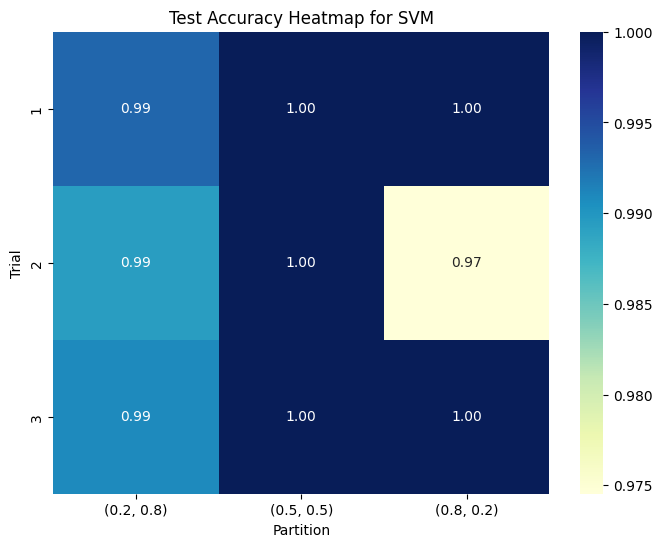


-------- RandomForest--------

-------- trial 1 --------
partition 20/80: train acc: 1.00, val acc: 0.98, test acc: 0.98
partition 50/50: train acc: 1.00, val acc: 1.00, test acc: 1.00
partition 80/20: train acc: 1.00, val acc: 0.99, test acc: 0.99

-------- trial 2 --------
partition 20/80: train acc: 1.00, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 1.00, val acc: 1.00, test acc: 0.99
partition 80/20: train acc: 1.00, val acc: 1.00, test acc: 1.00

-------- trial 3 --------
partition 20/80: train acc: 1.00, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 1.00, val acc: 0.99, test acc: 1.00
partition 80/20: train acc: 1.00, val acc: 0.98, test acc: 0.98


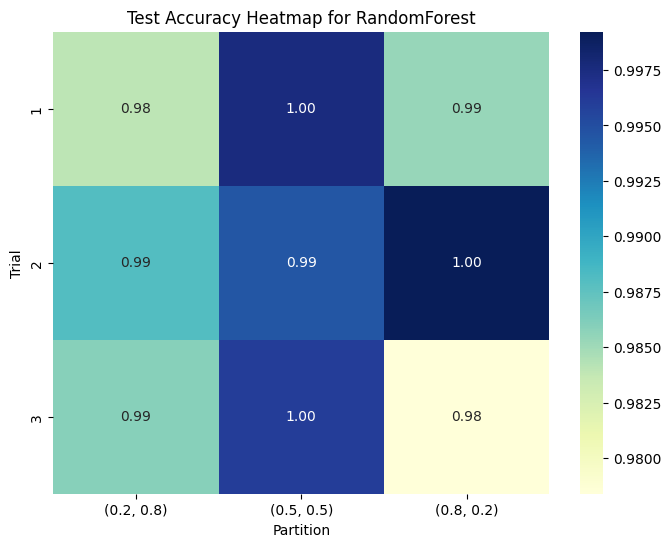


-------- LogisticRegression--------

-------- trial 1 --------
partition 20/80: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 80/20: train acc: 0.99, val acc: 0.99, test acc: 0.99

-------- trial 2 --------
partition 20/80: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 80/20: train acc: 0.99, val acc: 0.99, test acc: 0.99

-------- trial 3 --------
partition 20/80: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 50/50: train acc: 0.99, val acc: 0.99, test acc: 0.99
partition 80/20: train acc: 0.99, val acc: 0.99, test acc: 0.99


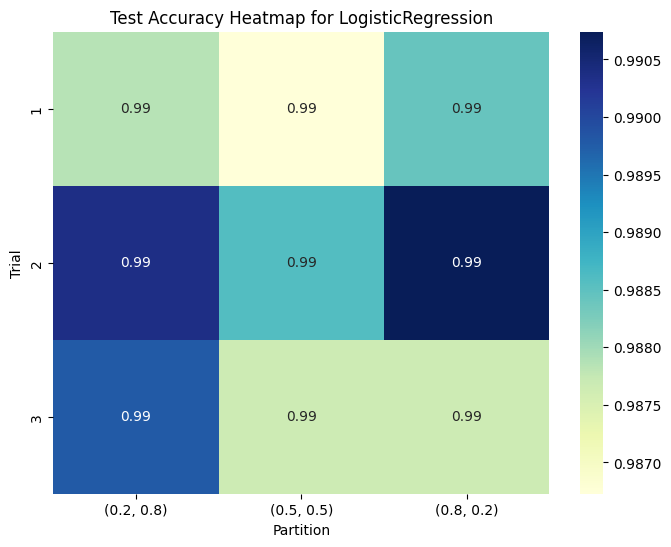


--------model summary--------

SVM:
  average test acc: 0.99
  average CV acc: 0.99
  best hyperparams: {'kernel': 'rbf', 'gamma': 0.001, 'degree': 3, 'C': 1000}

RandomForest:
  average test acc: 0.99
  average CV acc: 0.99
  best hyperparams: {'max_features': 4}

LogisticRegression:
  average test acc: 0.99
  average CV acc: 0.99
  best hyperparams: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1000}


In [16]:
main()